#**Procedure of our program**

In [ ]:
"""
Steps to be taken for this implementation:

1. Create an Interactive Session
2. Load the content image
3. Load the style image
4. Randomly initialize the image to be generated
5. Load the VGG19 model
6. Build the TensorFlow graph:
      Run the content image through the VGG19 model and compute the content cost
      Run the style image through the VGG19 model and compute the style cost
7. Compute the total cost
8. Define the optimizer and the learning rate
9. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every step

"""

'\nSteps to be taken for this implementation:\n\n1. Create an Interactive Session\n2. Load the content image\n3. Load the style image\n4. Randomly initialize the image to be generated\n5. Load the VGG19 model\n6. Build the TensorFlow graph:\n      Run the content image through the VGG19 model and compute the content cost\n      Run the style image through the VGG19 model and compute the style cost\n7. Compute the total cost\n8. Define the optimizer and the learning rate\n9. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every step\n\n'

# **Importing libraries**

In [ ]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.python.framework import ops
import imageio

%matplotlib inline

#**Creating intereactive session** 

In [ ]:
# Reset the graph
ops.reset_default_graph()

# Start interactive session
sess = tf.compat.v1.InteractiveSession()

tf.compat.v1.disable_eager_execution()

#**Class for VGG model**

In [ ]:
class CONFIG:
    IMAGE_WIDTH = 210
    IMAGE_HEIGHT = 240
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    VGG_MODEL = 'drive/My Drive/neural style transfer/vgg model/imagenet-vgg-verydeep-19.mat'  # Pick the VGG 19-layer model by from the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition".
    STYLE_IMAGE = 'drive/My Drive/neural style transfer/images/stone_style.jpg' # Style image to use.
    CONTENT_IMAGE = './f1.jpg'   #'drive/My Drive/neural style transfer/images/content300.jpg' # Content image to use.
    OUTPUT_DIR = 'drive/My Drive/neural style transfer/output/'
  
    
def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b


    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filters=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph



In [ ]:
# Function for generating a noise image by adding random noise to the content image
def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image


# Function for resizing, reshaping and normalizing the image
def reshape_and_normalize_image(image):
    
    # Reshape image to mach expected input of VGG16
    image = cv2.resize(image, (210,240), interpolation = cv2.INTER_AREA )    
    image = np.reshape(image, ((1,) + image.shape))
    
    # Substract the mean to match the expected input of VGG16
    image = image - CONFIG.MEANS
    
    return image


# Function to save the image
def save_image(path, image):
    
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    imageio.imwrite(path,image)

https://arxiv.org/pdf/1508.06576.pdf


#**Mounting drive for content images**

In [ ]:
# Mounting drive for images and model
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**Loading style, content images and generating noise image**
##**Selecting layers for experimenting**

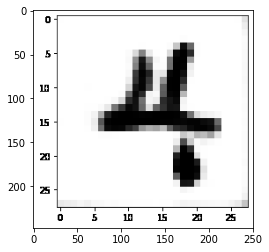

(248, 251, 3)


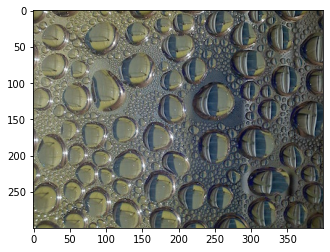

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


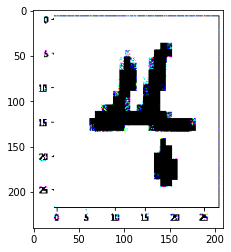

In [ ]:
# Loading images

content_image = cv2.imread('./four.png' ) #"drive/My Drive/neural style transfer/images/louvre.jpg")
plt.imshow(content_image)
plt.show()
print(content_image.shape)
content_image = reshape_and_normalize_image(content_image)


style_image = cv2.imread("drive/My Drive/neural style transfer/images/drop-of-water.jpg")
plt.imshow(style_image)
plt.show()
style_image = reshape_and_normalize_image(style_image)

generated_image = generate_noise_image(content_image)
plt.imshow(generated_image[0])
plt.show()

# Different layers with weights to mix style from style image. We have to experiment with these
# Weights add to 1
 
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

##**Loading vgg model**

In [ ]:
# We are using pretrained vgg model
model = load_vgg_model("drive/My Drive/neural style transfer/vgg model/imagenet-vgg-verydeep-19.mat")

In [ ]:
# Function to compute content cost

def compute_content_cost(a_C, a_G):
    """
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image content img
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image generated img

    """
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshaping a_C and a_G
    #tf.reshape(a_C, shape=[m, n_H * n_W, n_C]) gives the same result as tf.reshape(a_C, shape=[m, -1, n_C])
    a_C_unrolled = tf.reshape(a_C,[m,-1,n_C])
    a_G_unrolled = tf.reshape(a_G,[m,-1,n_C])
    
    # computing cost
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))/(4*n_H*n_W*n_C)
    
    return J_content

In [ ]:
# Function to calculate gram_matrix(similarity in style activation of matrix)

def gram_matrix(A):
    """
    A -- matrix of shape (n_C, n_H*n_W)
    
    """
    GA = tf.matmul(A,A,transpose_b=True)
    
    return GA

In [ ]:
# Function to compute layer style cost
def compute_layer_style_cost(a_S, a_G):
    """
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    """
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_H*n_W, n_C) 
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))

    # Computing gram_matrices for both images S and G 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss
    J_style_layer = tf.reduce_sum(tf.square(GS-GG)) / (2*n_C*n_W * n_H)**2
    
    return J_style_layer

In [ ]:
# Function to compute total style cost

def compute_style_cost(model, STYLE_LAYERS):
    """
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    """
    
    J_style = 0

    for layer_name, weight in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)      

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out          
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += weight * J_style_layer

    return J_style

In [ ]:
# Function to find total_cost

def total_cost(J_content, J_style, alpha = 25, beta = 25):
    """
    J_content -- content cost 
    J_style -- style cost 
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost

    """
    J = alpha*J_content + beta*J_style
    
    return J

#**Running session**

In [ ]:
# Assign the content image to be the input of the VGG model.  
'''To run an image through this network, you just have to feed the image to the model. In TensorFlow, you can do so using the tf.assign function. In particular, you will use the assign function like this:
model["input"].assign(image)

This assigns the image as an input to the model '''

sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
''' if you want to access the activations of a particular layer, say layer 4_2 when the network is run on this image, you would run a TensorFlow session on the correct tensor conv4_2, as follows:
sess.run(model["conv4_2"]) '''

out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

J = total_cost(J_content,J_style,1,10)

#**Optimizer**

In [ ]:
# define optimizer
#optimizer = tf.optimizers.Adam(2.0)
optimizer = tf.compat.v1.train.AdamOptimizer(2.0)

# define train_step
train_step = optimizer.minimize(J)

#**Main model function**

In [ ]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables 
    sess.run(tf.compat.v1.global_variables_initializer())
    
    # Run the noisy input image
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("drive/My Drive/neural style transfer/output/" + str(i) + ".png", generated_image)
            save_image("drive/My Drive/mlProject_CycleGAN/output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('drive/My Drive/neural style transfer/output/generated_image.jpg', generated_image)
    
    return generated_image

In [ ]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 374558750.0
content cost = 20946.207
style cost = 37453780.0
Iteration 20 :
total cost = 57861948.0
content cost = 30253.91
style cost = 5783169.5
Iteration 40 :
total cost = 29442620.0
content cost = 32264.994
style cost = 2941035.5
Iteration 60 :
total cost = 19182180.0
content cost = 33029.06
style cost = 1914915.0
Iteration 80 :
total cost = 14145563.0
content cost = 33539.37
style cost = 1411202.4
Iteration 100 :
total cost = 11269196.0
content cost = 33894.145
style cost = 1123530.2
Iteration 120 :
total cost = 9421538.0
content cost = 34162.152
style cost = 938737.56
Iteration 140 :
total cost = 8124860.0
content cost = 34380.668
style cost = 809047.94
Iteration 160 :
total cost = 7162791.5
content cost = 34567.07
style cost = 712822.44
Iteration 180 :
total cost = 6417670.0
content cost = 34715.836
style cost = 638295.4


array([[[[134.76532  ,  53.083515 ,  65.85189  ],
         [ 23.304651 ,  12.767825 ,  15.99047  ],
         [ 11.437552 ,   7.8616686,  17.842669 ],
         ...,
         [ 83.16468  ,  48.721767 ,  77.86631  ],
         [ 10.094035 ,  29.291443 ,  31.74911  ],
         [ -2.0832589,  25.438623 ,  36.384747 ]],

        [[ 42.837944 ,  33.882275 ,  50.773746 ],
         [-19.843042 ,  17.856476 ,  23.9956   ],
         [-23.731537 , -11.767937 ,  12.873563 ],
         ...,
         [ 62.21181  ,  89.06338  ,  92.047516 ],
         [ 71.212524 ,  30.868664 ,  60.57854  ],
         [ 38.880123 ,  20.366829 ,  56.34629  ]],

        [[ 41.6357   ,  35.328274 ,  40.419174 ],
         [ -8.098626 ,   7.1528344,  16.857914 ],
         [ -8.4759245, -17.855547 ,  22.794369 ],
         ...,
         [ 43.032547 ,   5.108542 ,  42.69897  ],
         [ 56.79494  ,  18.276583 ,  65.6783   ],
         [ 57.81978  ,  50.025826 ,  64.37198  ]],

        ...,

        [[ 70.59984  ,  62.474117 ,  5